# Caída Libre (Newton)

In [1]:
%reset -f

import sympy as smp
import numpy as np

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt

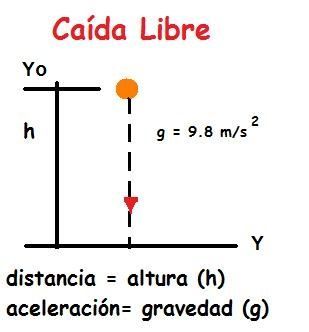

Define los simbolos apropiados en sympy

In [2]:
t, g, m = smp.symbols('t g m', positive=True)
F, a = smp.symbols('F a', real=True)

$$\vec{F} = m\vec{a}$$

Al ser caída libre solo tenemos una componente para la aceleración y la fuerza

$$F_{y} = ma_{y}$$

In [16]:
Eq = smp.Eq(F, m*a)
Eq

Eq(F, a*m)

$y$ es una función dependiente del tiempo

In [29]:
y = smp.Function('y', real=True)
y = y(t)

Definimos las dos primeras derivadas temporales de $y$

In [43]:
d1_y = smp.diff(y, t)
d2_y = smp.diff(d1_y, t)

La fuerza de gravedad solo actúa en el eje $y$

In [45]:
Fy = -m*g

La aceleracíon es: $a = \ddot{y}$ <br>
Se sustituyen fuerzas y aceleraciones:

In [46]:
Eq

Eq(F, a*m)

In [51]:
Eq = Eq.subs([
    [F, Fy],
    [a, d2_y]
])
Eq

Eq(-g*m, m*Derivative(y(t), (t, 2)))

## Solución Exacta (integrate)

In [52]:
Eq

Eq(-g*m, m*Derivative(y(t), (t, 2)))

La ecuación de movimiento obtenida se puede resolver por separación de variables e integrando, primero tenemos que despejar la segunda derivada $\ddot{y}$

In [58]:
d2_y_explicit = smp.solve([Eq], [d2_y])[d2_y]

Definimos dos constantes (de integración) $C_1$ y $C_2$ e integramos 2 veces con respecto a $t$ para obtener la función de velocidad y posición

In [59]:
C1, C2 = smp.symbols('C1 C2')

In [74]:
d1_y_explicit = smp.integrate(d2_y_explicit, t) + C2
d1_y_explicit

C2 - g*t

In [78]:
y_explicit = smp.integrate(d1_y_explicit, t) + C1
y_explicit

C1 + C2*t - g*t**2/2

Integrando dos veces, se obtuvo la solución exacta de la ecuación de movimiento

## Solución Exacta (dsolve)

In [81]:
Eq

Eq(-g*m, m*Derivative(y(t), (t, 2)))

Otra forma de resolver la ecuación de movimiento es resolviendo directamente y de forma simbólica con la función **dsolve**

In [92]:
y_explicit = smp.dsolve(Eq, y).args[1]
y_explicit

C1 + C2*t - g*t**2/2

Derivando dos veces la ecuación obtenida podemos obtener la velocidad y la aceleración

In [94]:
d1_y_explicit = smp.diff(y_explicit, t)
d1_y_explicit

C2 - g*t

## Solución Exacta con Condiciones Iniciales (dsolve)

In [96]:
Eq

Eq(-g*m, m*Derivative(y(t), (t, 2)))

**dsolve** también se puede utilizar para resolver las ecuaciones diferenciales usando valores iniciales <br>
Estos valores iniciales tienen que guardarse en un diccionario

In [111]:
t0 = 0
y0 = 500
vy0 = 0
S0 = {y.subs(t, t0):y0, d1_y.subs(t, t0):vy0}

Con este método ya no aparecen las constantes de integración

In [120]:
y_explicit = smp.dsolve(Eq, y, ics=S0).args[1]
y_explicit

-g*t**2/2 + 500

Derivando se puede obtener la velocidad y la aceleración

In [121]:
d1_y_explicit = smp.diff(y_explicit, t)
d1_y_explicit

-g*t

La solución de la ecuación de movimiento (y la velocidad) es casi la misma que las anteriores, a esta se le definieron condiciones iniciales, ahora las transformamos en funciones de python-numpy con **lambdify**

In [130]:
y_exact = smp.lambdify((t, g), y_explicit, modules='numpy')
d1_y_exact = smp.lambdify((t, g), d1_y_explicit, modules='numpy')

Creamos un intervalo del tiempo en el que queremos evaluar la solución y otras propiedades como la masa y la aceleración de la gravedad

In [139]:
t0 = 0
tf = 10
t_size = 1001
t = np.linspace(t0, tf, t_size)

In [140]:
g = 9.81

Evaluamos la velcidad y la posición

In [144]:
y_sol_exact = y_exact(t, g)
d1_y_sol_exact = d1_y_exact(t, g)

Graficamos

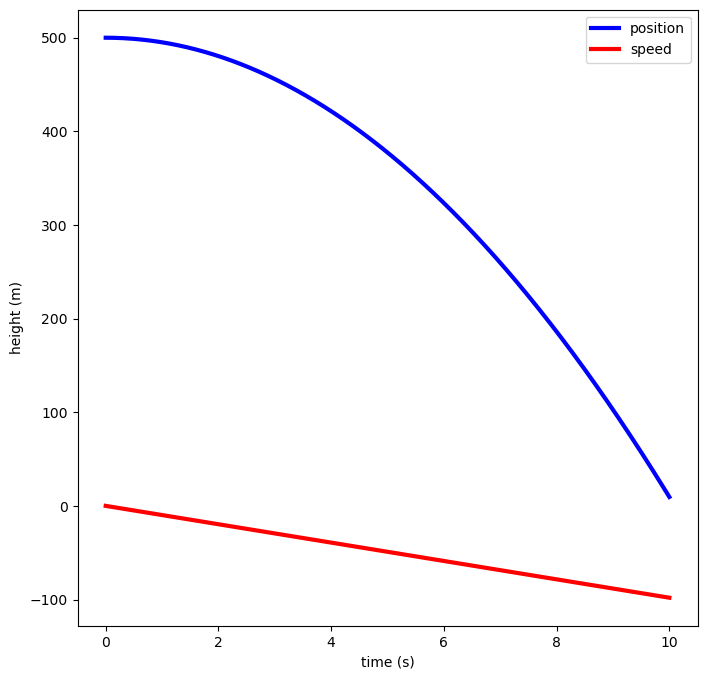

In [149]:
plt.figure(figsize=(8, 8))

plt.plot(t, y_sol_exact, lw=3, c='blue', label='position')
plt.plot(t, d1_y_sol_exact, lw=3, c='red', label='speed')

plt.xlabel('time (s)')
plt.legend()
plt.show()

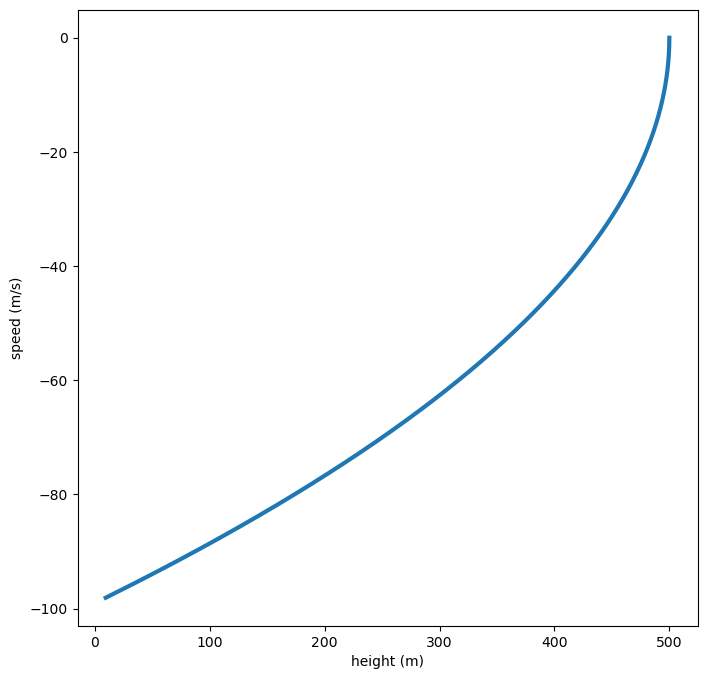

In [150]:
plt.figure(figsize=(8, 8))
plt.plot(y_sol_exact, d1_y_sol_exact, lw=3)
plt.xlabel('height (m)')
plt.ylabel('speed (m/s)')
plt.show()

## Solución Numerica

Volvemos a definir algunos simbolos ya que los habíamos sobre-escrito

In [151]:
t, g = smp.symbols('t g', positive=True)

Recordemos el despeje de la segunda derivada de $\ddot{y}$

In [154]:
Eq

Eq(-g*m, m*Derivative(y(t), (t, 2)))

In [158]:
d2_y_explicit = smp.solve([Eq], [d2_y])[d2_y]
d2_y_explicit

-g

Para resolver numericamente la ecuación de segundo orden se tiene que transformar en un sistema de ecuaciones de primer orde, para eso realizamos la siguiente sustitución <br>
<ul>
  <li>$\dot{y} = z$</li>
  <li>$\dot{z} = \ddot{y} = -g$</li>
</ul> 
y este sistema lo transformamos en funciones númericas

In [159]:
dy_dt_f = smp.lambdify(d1_y, d1_y, modules='numpy')
dz_dt_f = -9.8

Se define un vector $\vec{S} = (y, z)$ y una función que toma $\vec{S}$ y $t$, y devuelve $\dot{S}$ para poder resolver el sistema de ecuaciones

In [160]:
def dSdt(t, S):
    y, z = S
    return [
        dy_dt_f(z),
        dz_dt_f
    ]

Definimos un arreglo de puntos en el tiempo en el cual queremos obtener la solución

In [162]:
t0 = 0
tf = 10
t_size = 1001
t = np.linspace(t0, tf, t_size)

Se definen algunas constantes (aceleración de la gravedad y masa) que se guardan en la lista args y se definen las condiciones iniciales (posición:y0, velocidad: vy0) que se guardan en la lista S0

In [163]:
y0 = 500
vy0 = 0
S0 = [y0, vy0]

Se utiliza la función solve_ivp para resolver la ecuación diferencial

In [164]:
sol = solve_ivp(dSdt, t_span=(t0, tf), y0=S0, method='RK45', t_eval=t)

Guardamos la solución y se grafica

In [170]:
y_sol_numeric = sol.y[0]
d1_y_sol_numeric = sol.y[1]

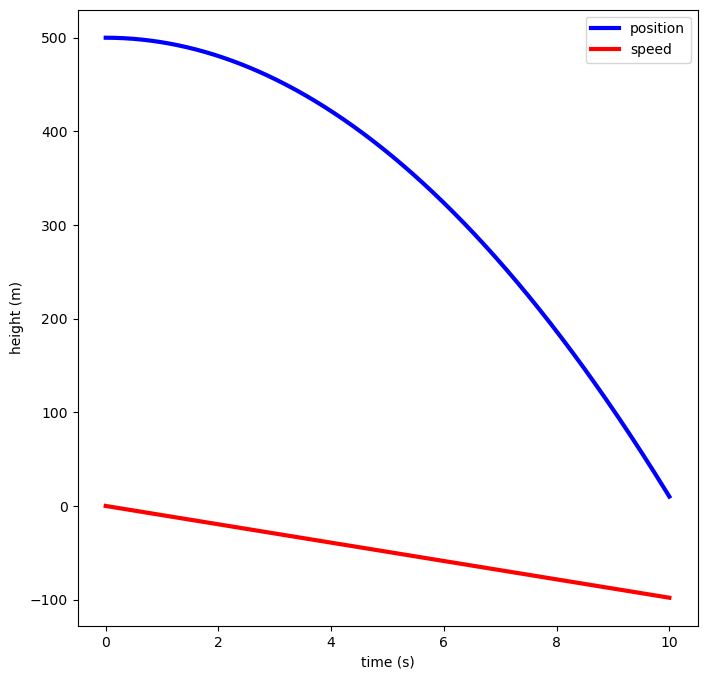

In [172]:
plt.figure(figsize=(8, 8))
plt.plot(t, y_sol_numeric, lw=3, c='blue', label='position')
plt.plot(t, d1_y_sol_numeric, lw=3, c='red', label='speed')
plt.xlabel('time (s)')
plt.legend()
plt.show()

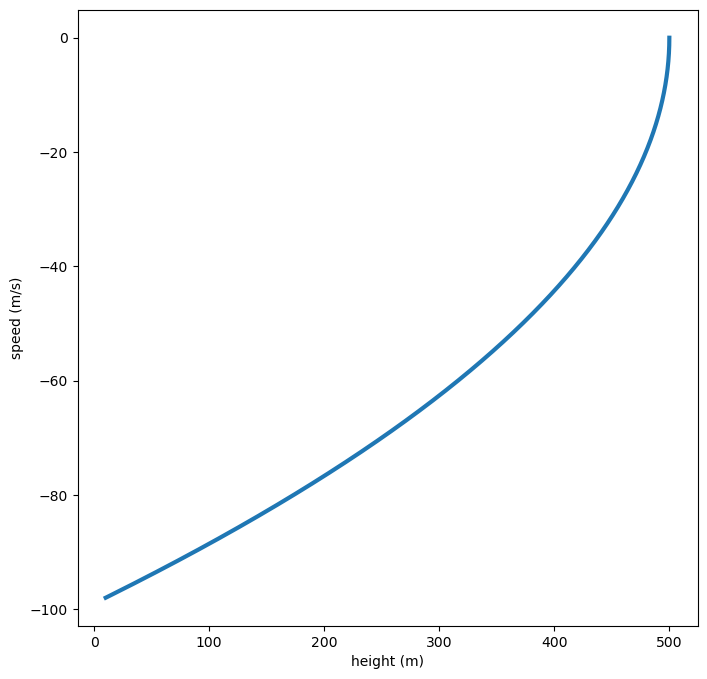

In [173]:
plt.figure(figsize=(8, 8))
plt.plot(y_sol_numeric, d1_y_sol_numeric, lw=3)
plt.xlabel('height (m)')
plt.ylabel('speed (m/s)')
plt.show()

## Solución Exacta vs Numerica

Comparamos la solución exacta y númerica para la posición, velocidad y gráfica de fase, los resultados son identicos, esto se debe a la simpleza del problema

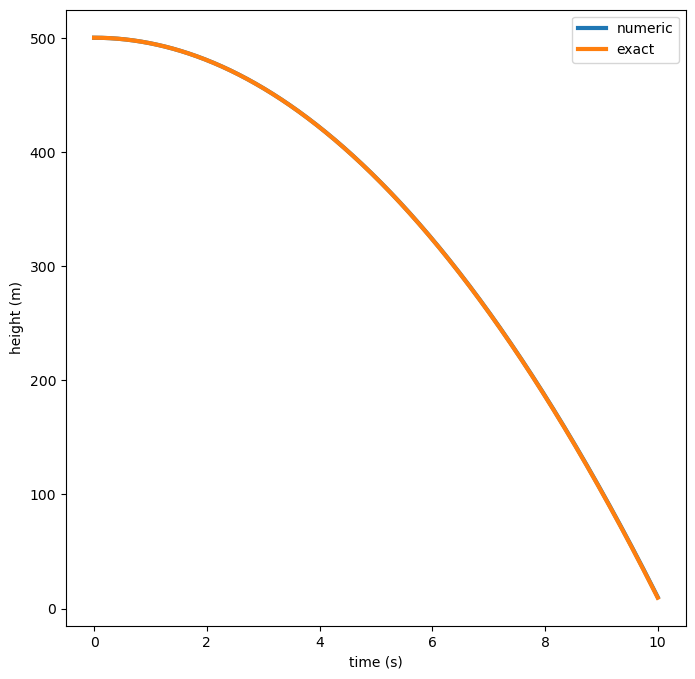

In [174]:
plt.figure(figsize=(8, 8))
plt.plot(t, y_sol_numeric, lw=3, label='numeric')
plt.plot(t, y_sol_exact, lw=3, label='exact')
plt.xlabel('time (s)')
plt.ylabel('height (m)')
plt.legend()
plt.show()

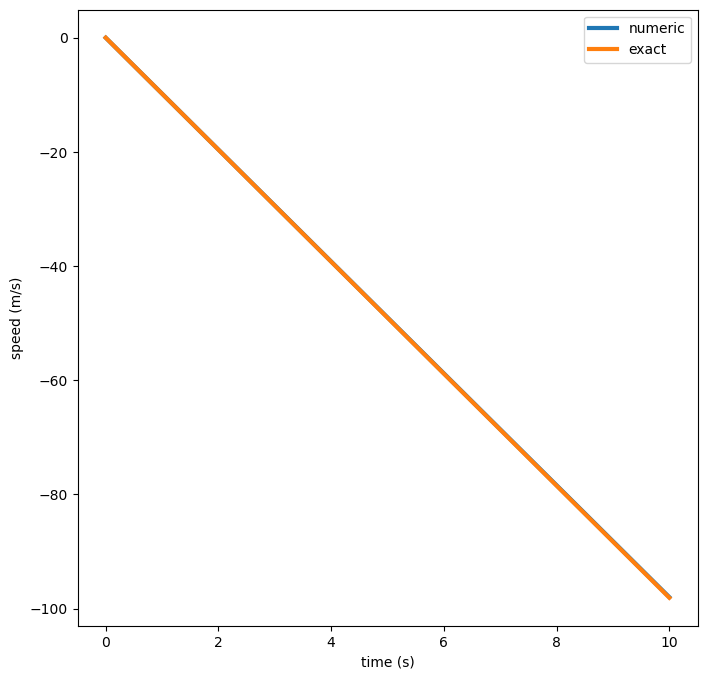

In [175]:
plt.figure(figsize=(8, 8))
plt.plot(t, d1_y_sol_numeric, lw=3, label='numeric')
plt.plot(t, d1_y_sol_exact, lw=3, label='exact')
plt.xlabel('time (s)')
plt.ylabel('speed (m/s)')
plt.legend()
plt.show()

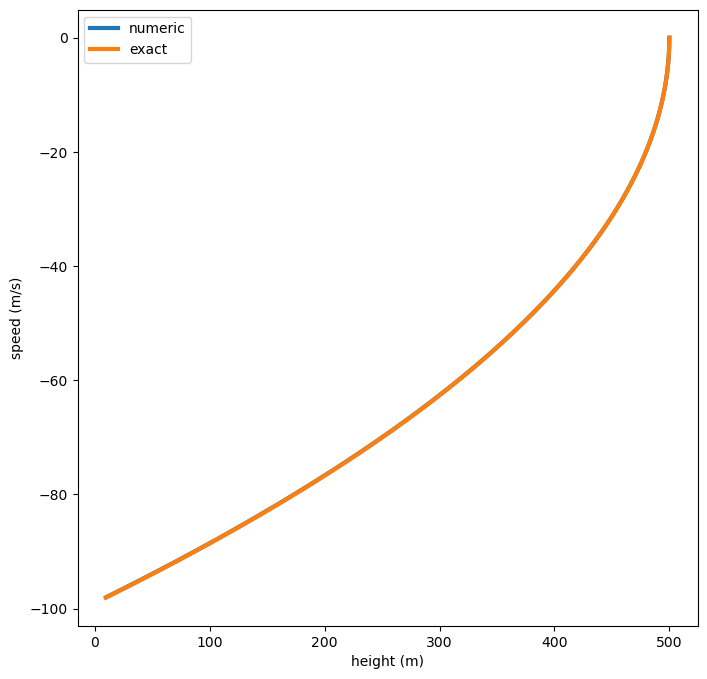

In [176]:
plt.figure(figsize=(8, 8))
plt.plot(y_sol_numeric, d1_y_sol_numeric, lw=3, label='numeric')
plt.plot(y_sol_exact, d1_y_sol_exact, lw=3, label='exact')
plt.xlabel('height (m)')
plt.ylabel('speed (m/s)')
plt.legend()
plt.show()